In [1]:
from models.spk_subunit_nn import Spk_Subunit_NN

import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub4_C_syn_e.npy"
C_syn_i_file = "handsub4_C_syn_i.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)

#E_neural = torch.from_numpy(E_neural)
#I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
V = torch.from_numpy(V)

#V -= torch.mean(V)
#V[V < 0.4] = 0

In [3]:
T_train = 149 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 501
H_no = 3
sub_no = 153
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 1000
iter_no = 10000
epoch_no = iter_no*batch_size//T_train 

In [4]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()
#test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
#test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
#train_E_neural = E_neural[:T_train].float()
#train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
model = Spk_Subunit_NN(C_syn_e, C_syn_i, T_no, H_no, device)

#optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

585


In [6]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred, conv_kern, hist_kern, spk_out, sub_thresh = model(batch_E_neural, batch_I_neural)
            
    #loss = torch.var(V_pred - batch_V)
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_conv_kern, test_hist_kern, test_spk_out, test_sub_thresh = model(test_E_neural, test_I_neural)
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        
        print(i, test_score, torch.sum(test_spk_out[:16000]).item(), torch.mean(model.Tau_root).item(), torch.mean(model.W_root).item())


<ipython-input-6-088c106f7d38>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 -36.728607177734375 138.0 1.9925000667572021 0.9925000071525574
49 0.0 0.0 1.955220341682434 0.9552032947540283
99 0.0 0.0 1.9549181461334229 0.9549012184143066
149 0.0 0.0 1.95491623878479 0.9548991322517395



KeyboardInterrupt: 

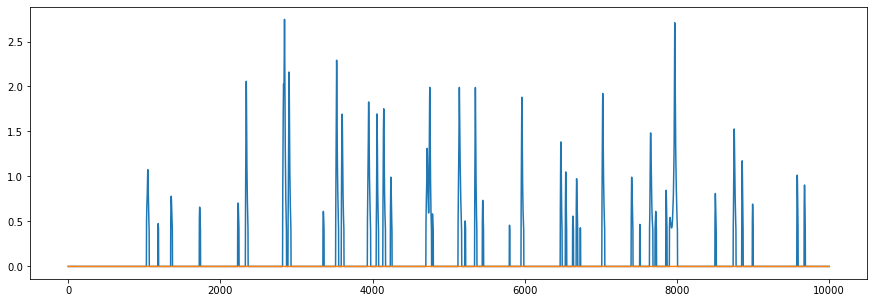

In [7]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])

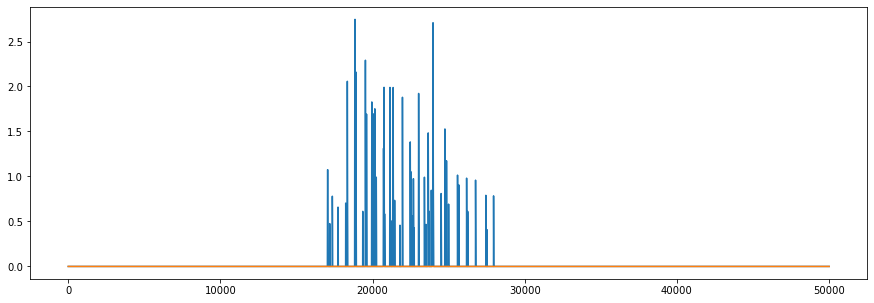

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.cpu().detach().numpy())

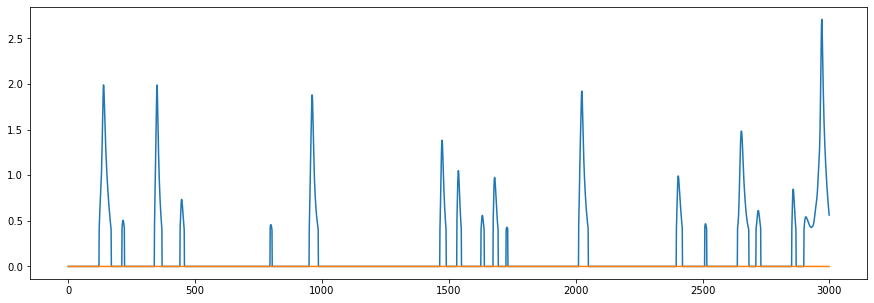

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[21000:24000])
plt.plot(test_V_pred.cpu().detach().numpy()[21000:24000])

In [5]:
spikes = torch.matmul(test_E_neural.cpu(), C_syn_e.T.cpu())
spikes_pad = torch.zeros(test_E_neural.shape[0]+101,4)
spikes_pad[101:] = spikes

t = torch.arange(101).reshape(1,-1).repeat(4,1)
t_tau = t / 10
kern = t_tau * torch.exp(-t_tau)
kern = torch.flip(kern, [1]).unsqueeze(1)


conv = F.conv1d(spikes_pad.T.unsqueeze(0), kern, padding=0, groups=4).squeeze(0).T

print(spikes.shape)

torch.Size([50000, 4])


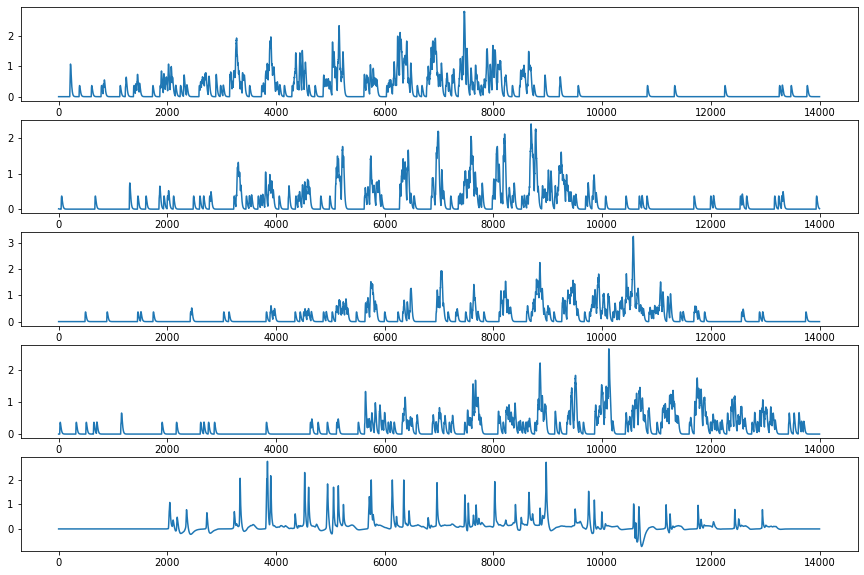

In [6]:
fig, axs = plt.subplots(nrows=5, figsize= (15,10))
for i in range(4):
    axs[i].plot(conv[:,i].cpu().detach().numpy()[15000:29000])
axs[-1].plot(V_test.cpu().detach().numpy()[15000:29000])

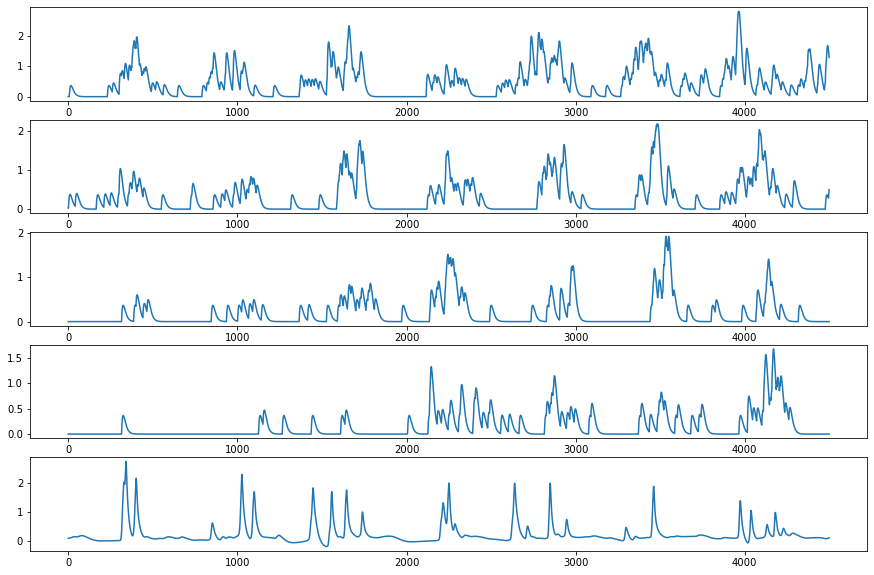

In [7]:
fig, axs = plt.subplots(nrows=5, figsize= (15,10))
for i in range(4):    
    axs[i].plot(conv[:,i].cpu().detach().numpy()[15000:29000][3500:8000])
axs[-1].plot(V_test.cpu().detach().numpy()[15000:29000][3500:8000])